In [44]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import set_config

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
set_config(display="diagram")

In [45]:
df = pd.read_csv('./hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Number of Bookings By Months

In [46]:
bookings_by_month = df.groupby('arrival_date_month', as_index=False)['hotel'].count().rename(columns={'hotel': 'count'})
display(bookings_by_month)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig = px.bar(bookings_by_month, x = 'arrival_date_month', y = 'count', title = 'Bookings by Month', category_orders = {'arrival_date_month': months})

fig.show()

,arrival_date_month,count
0,April,11089
1,August,13877
2,December,6780
3,February,8068
4,January,5929
5,July,12661
6,June,10939
7,March,9794
8,May,11791
9,November,6794


Our objective is to build a classification model - or classifier - that predicts whether or not a user cancelled a hotel booking.

## Split the data into training and test sets.

In [47]:
numeric_features = [
    "lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies", "is_repeated_guest" ,
    "previous_cancellations", "previous_bookings_not_canceled", "agent", "company",
    "required_car_parking_spaces", "total_of_special_requests", "adr"
]

categoric_features = [
    "hotel", "arrival_date_month", "meal", "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type"
]

features = numeric_features + categoric_features
X = df[features]
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)


## 2. Preprocess the data

The next step is to set up a pipeline to preprocess the features. We will impute all missing values with a constant, and one-hot encode all categorical features.

In [50]:
missing_values = X_train[numeric_features].isnull().sum()
print(missing_values)

print(X_train[numeric_features][X_train[numeric_features].isnull().any(axis=1)])


lead_time                             0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
agent                             13034
company                           90111
required_car_parking_spaces           0
total_of_special_requests             0
adr                                   0
dtype: int64
        lead_time  arrival_date_week_number  arrival_date_day_of_month  \
85242           8                        11                          9   
65604          93                        14                          6   
17345          90                        39                         23   
117786          8                        32        

In [51]:
impute_numeric = SimpleImputer(strategy="constant")

encode_categorical = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", impute_numeric, numeric_features),
    ("cat", encode_categorical, categoric_features)
])

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['lead_time', 'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled', 'agent',
                                  'company', 'required_car_parking_spaces',
                                  'total_of_special_requests', 'adr']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'market_segment', 'distribution_channel',
                                  'reserved_room_type', 'deposit_type',
                                  'customer_type'])])

In [52]:
steps = Pipeline(steps = [
	('preprocessor', preprocessor),
	('classifier', DecisionTreeClassifier(random_state=42))
])

steps.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'agent', 'company',
                                                   'r...
                                                   'total_of_special_requests',
                                                   'adr']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

0.8212161822598207


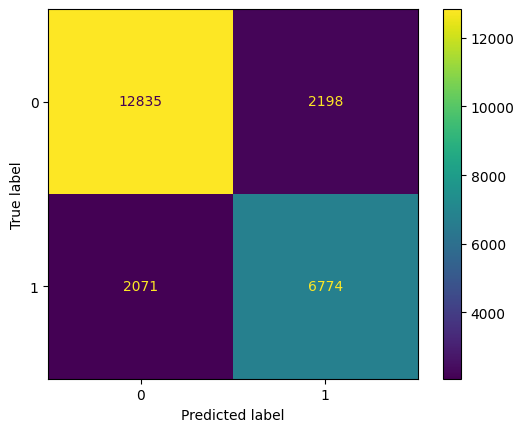

In [56]:
print(steps.score(X_test, y_test))

cm = confusion_matrix(y_test, steps.predict(X_test))

ConfusionMatrixDisplay(cm).plot()

In [58]:
y_pred = steps.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8212161822598207


With this pipeline, we can now predict whether or not a new booking will be cancelled with an accuracy of 82%. This can be useful in planning room availability or identifying which guests are at risk of cancelling their booking to take corrective action.